In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


PyTorch Version: 2.0.1+cu118
CUDA Available: True
CUDA Version: 11.8
GPU Name: NVIDIA GeForce GTX 1060 6GB


In [7]:
print(f"Total frames detected: {len(frame_files)}")
print("Sample frames:", frame_files[:5])  # Print first 5 frame names


Total frames detected: 75
Sample frames: ['D:\\visual_speaker_auth\\output\\framesample\\s1\\bbaf2n\\frame_0000.jpg', 'D:\\visual_speaker_auth\\output\\framesample\\s1\\bbaf2n\\frame_0001.jpg', 'D:\\visual_speaker_auth\\output\\framesample\\s1\\bbaf2n\\frame_0002.jpg', 'D:\\visual_speaker_auth\\output\\framesample\\s1\\bbaf2n\\frame_0003.jpg', 'D:\\visual_speaker_auth\\output\\framesample\\s1\\bbaf2n\\frame_0004.jpg']


In [1]:
import cv2
print(cv2.__version__)  # Should print a valid version
print(cv2.getBuildInformation())  # Should show "opencv-contrib" support


4.11.0

General configuration for OpenCV 4.11.0 =====================================
  Version control:               4.11.0

  Extra modules:
    Location (extra):            D:/a/opencv-python/opencv-python/opencv_contrib/modules
    Version control (extra):     4.11.0

  Platform:
    Timestamp:                   2025-01-16T09:56:43Z
    Host:                        Windows 10.0.17763 AMD64
    CMake:                       3.24.2
    CMake generator:             Visual Studio 14 2015
    CMake build tool:            MSBuild.exe
    MSVC:                        1900
    Configuration:               Debug Release
    Algorithm Hint:              ALGO_HINT_ACCURATE

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 AVX FP16 AVX2
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE

In [29]:
import numpy as np
import os

# 📌 Path to real optical flow directory
real_optical_flow_dir = r"D:\visual_speaker_auth\data\gridcorpus\optical_flow\reall\s7"

# ✅ Load a sample real optical flow file
real_files = sorted([f for f in os.listdir(real_optical_flow_dir) if f.endswith(".npy")])

if len(real_files) == 0:
    print("❌ No real optical flow files found.")
else:
    real_path = os.path.join(real_optical_flow_dir, real_files[0])  # Load first file
    real_optical_flow = np.load(real_path)  # Shape: (num_frames, H, W, 2)

    print(f"✅ Real Optical Flow Shape: {real_optical_flow.shape}")  


✅ Real Optical Flow Shape: (74, 64, 64, 2)


In [1]:
import os
import cv2
import dlib
import numpy as np
from imutils import face_utils
from tqdm import tqdm
from scipy.interpolate import interp1d

# Path to the pre-trained Dlib 68-landmark predictor.
PREDICTOR_PATH = "D:/visual_speaker_auth/data/gridcorpus/shape_predictor_68_face_landmarks.dat"

# Initialize Dlib's face detector and shape predictor.
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Set target number of frames to match real optical flow
TARGET_FRAMES = 74  

def extract_lip_region(frame, target_size=(64, 64)):
    """
    Detects the face in the frame, extracts the lip region using Dlib's facial landmarks,
    and resizes it to the target size.
    Returns the cropped and resized lip region.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        return None
    rect = rects[0]  # Use the first detected face
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # Extract mouth region (landmarks 48-67)
    mouth = shape[48:68]
    (x, y, w, h) = cv2.boundingRect(mouth)
    lip_region = frame[y:y+h, x:x+w]
    lip_region_resized = cv2.resize(lip_region, target_size)
    
    return lip_region_resized

def interpolate_optical_flow(flow_seq, target_frames=TARGET_FRAMES):
    """
    Interpolates optical flow frames to match a fixed number of frames (T, 64, 64, 2).
    - If sequence is too short, it uses interpolation instead of padding.
    - If sequence is too long, it is trimmed.
    """
    num_frames, h, w, c = flow_seq.shape

    if num_frames < target_frames:  # Interpolate if too short
        x_old = np.linspace(0, 1, num=num_frames)  # Original frame positions
        x_new = np.linspace(0, 1, num=target_frames)  # New interpolated positions

        interpolated_flow = np.zeros((target_frames, h, w, c))  # Create empty array

        for i in range(c):  # Interpolate separately for each flow direction (x & y)
            for j in range(h):
                for k in range(w):
                    f = interp1d(x_old, flow_seq[:, j, k, i], kind='linear', fill_value="extrapolate")
                    interpolated_flow[:, j, k, i] = f(x_new)

        return interpolated_flow

    elif num_frames > target_frames:  # Trim if too long
        return flow_seq[:target_frames]

    else:
        return flow_seq  # Already the correct shape

def compute_optical_flow(video_path, output_folder, target_size=(64, 64)):
    """
    Processes a single video by:
      - Opening the video,
      - Extracting the lip region from the first frame,
      - Computing the optical flow (using Farneback's algorithm) between consecutive lip regions,
      - Interpolating missing frames to ensure a fixed number of frames (T, 64, 64, 2),
      - Saving the array as a .npy file in the output folder.
    If an output file already exists for the video, processing is skipped.
    """
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_path = os.path.join(output_folder, video_name + ".npy")

    # Skip if the output file already exists
    if os.path.exists(output_path):
        print(f"Skipping {video_path}: output already exists.")
        return

    cap = cv2.VideoCapture(video_path)
    ret, first_frame = cap.read()
    if not ret:
        print(f"Error reading video: {video_path}")
        cap.release()
        return

    lip_prev = extract_lip_region(first_frame, target_size)
    if lip_prev is None:
        print(f"No lip region detected in first frame of: {video_path}")
        cap.release()
        return

    lip_prev_gray = cv2.cvtColor(lip_prev, cv2.COLOR_BGR2GRAY)
    flow_maps = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        lip_curr = extract_lip_region(frame, target_size)
        if lip_curr is None:
            continue  # Skip frame if lip region not detected
        lip_curr_gray = cv2.cvtColor(lip_curr, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(lip_prev_gray, lip_curr_gray, None,
                                            pyr_scale=0.5, levels=3, winsize=15,
                                            iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
        flow_maps.append(flow)
        lip_prev_gray = lip_curr_gray.copy()

    cap.release()

    if not flow_maps:
        print(f"No optical flow computed for video: {video_path}")
        return

    flow_seq = np.array(flow_maps)  # Shape: (T, H, W, 2)
    
    # Ensure all sequences have 74 frames
    flow_seq = interpolate_optical_flow(flow_seq)

    np.save(output_path, flow_seq)
    print(f"Saved optical flow for {video_path} to {output_path} with shape {flow_seq.shape}")

def process_fake_dataset(base_video_dir, base_flow_dir, target_size=(64, 64)):
    """
    Processes the fake dataset:
      - Iterates through each user folder (s1 to s33),
      - For each video in the user's folder, computes the optical flow using the above function,
      - Saves one .npy file per video in a corresponding output folder (maintaining a 1:1 mapping).
    """
    for user in os.listdir(base_video_dir):
        user_video_dir = os.path.join(base_video_dir, user)
        if not os.path.isdir(user_video_dir):
            continue
        user_flow_output_dir = os.path.join(base_flow_dir, user)
        os.makedirs(user_flow_output_dir, exist_ok=True)
        video_files = [f for f in os.listdir(user_video_dir) if f.lower().endswith(('.mp4', '.avi', '.mpg'))]
        for video_file in tqdm(video_files, desc=f"Processing fake videos for user {user}"):
            video_path = os.path.join(user_video_dir, video_file)
            compute_optical_flow(video_path, user_flow_output_dir, target_size)

if __name__ == "__main__":
    # Base directory for fake video files and the output directory for optical flow files
    base_fake_video_dir = "D:/visual_speaker_auth/data/gridcorpus/fake_videos"  # Fake video files location
    base_fake_flow_dir = "D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake"  # Where to save one .npy file per video
    process_fake_dataset(base_fake_video_dir, base_fake_flow_dir, target_size=(64, 64))
    print("Optical flow extraction for fake dataset completed!") 


Processing fake videos for user s16: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4321.41it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbad7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbad9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbak1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbak3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbaq5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbaq7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbax9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbay2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\fake_bbbe1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s16\

Processing fake videos for user s17:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbad6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbad8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbak1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbak3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbaq4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbaq6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbax8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbay1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_bbbe1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\

Processing fake videos for user s17: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4848.49it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prah6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_pran8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prao1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prau2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prau4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prbb4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prbb6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prbh8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\fake_prbi1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s17\

Processing fake videos for user s1:   0%|                                                      | 0/498 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_test.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_test_v2.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbaf2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbaf2n_fixed.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbaf3s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbaf4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbaf5a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbal7s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_bbal9a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_

Processing fake videos for user s1: 100%|██████████████████████████████████████████| 498/498 [00:00<00:00, 4322.44it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbc2p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbczn.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbi5s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbi7a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbo9s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbpzp.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbv3s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swbv5a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swib3s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s1\fake_swib5

Processing fake videos for user s2:   0%|                                                      | 0/499 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbaf1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbaf2s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbaf3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbal5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbal7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbar9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbas2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbaz3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbaz5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_bbbf5

Processing fake videos for user s2: 100%|██████████████████████████████████████████| 499/499 [00:00<00:00, 4167.67it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwaq1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwaqzs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwax4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwax6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwbd8a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwbk1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwbkzs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwbq4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwbq6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s2\fake_pwbx8

Processing fake videos for user s3:   0%|                                                      | 0/496 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbaf1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbaf3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbal4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbal6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbar8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbas1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbaz2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbaz4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbbf4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_bbbf6

Processing fake videos for user s3: 100%|██████████████████████████████████████████| 496/496 [00:00<00:00, 4289.19it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_pric1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_pric3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_prii4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_prii6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_prio8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_prip1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_priv2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_priv4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_prwd2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s3\fake_prwd4

Processing fake videos for user s4:   0%|                                                      | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbae9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbaf2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbal3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbal5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbar7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbar9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbaz1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbaz3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbbf3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_bbbf5

Processing fake videos for user s4:  95%|████████████████████████████████████████  | 477/500 [00:00<00:00, 4441.90it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbb9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbi1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbi3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbo5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbo7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbu9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swbv2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swia9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swib2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s4\fake_swih3

Processing fake videos for user s5:   0%|                                                      | 0/499 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbae8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbaf1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbal2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbal4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbar6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbar8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbaz1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbaz3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbbf2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_bbbf4

Processing fake videos for user s5: 100%|██████████████████████████████████████████| 499/499 [00:00<00:00, 4141.39it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwaj2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwaj4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwap6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwap8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwax1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwax3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwbd2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwbd4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwbj6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s5\fake_pwbj8

Processing fake videos for user s6:   0%|                                                      | 0/497 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbae7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbae9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbal1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbal3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbar5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbar7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbay9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbaz2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbbf1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_bbbf3

Processing fake videos for user s6: 100%|██████████████████████████████████████████| 497/497 [00:00<00:00, 4711.77it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_sgwv9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_sraa5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_sraa7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_srag9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_srah2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_sran3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_sran5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_srat7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_srat9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s6\fake_srba9

Processing fake videos for user s7:   0%|                                                      | 0/494 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbae6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbae8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbal1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbal3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbar4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbar6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbay8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbaz1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbbf1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_bbbf3

Processing fake videos for user s7:  78%|████████████████████████████████▌         | 383/494 [00:00<00:00, 3676.33it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prib8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prii1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prii3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prio4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prio6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_priu8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_priv1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prwc8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prwd1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s7\fake_prwj2

Processing fake videos for user s8:   0%|                                                      | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbae5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbae7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbak9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbal2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbar3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbar5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbay7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbay9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbbe9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_bbbf2

Processing fake videos for user s8:  88%|█████████████████████████████████████     | 441/500 [00:00<00:00, 4401.13it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbah8s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbaiza.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbao2s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbao4a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbau6s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbau8a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbbb8s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbbcza.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbbi2s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s8\fake_pbbi4

Processing fake videos for user s9:   0%|                                                      | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbae4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbae6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbak8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbal1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbar2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbar4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbay6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbay8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbbe8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s9\fake_bbbf1

Processing fake videos for user s10:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbab8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbac1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbai2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbai4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbao6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbao8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbav1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbav3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_bbbc2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\

Processing fake videos for user s10:  92%|█████████████████████████████████████▋   | 459/500 [00:00<00:00, 4585.63it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_prwm8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_prwn1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_prwt2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_prwt4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_pwaa1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_pwag2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_pwag4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_pwam6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\fake_pwam8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s10\

Processing fake videos for user s11:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbae2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbae4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbak6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbak8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbar1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbar3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbay4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbay6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_bbbe6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\

Processing fake videos for user s11:  88%|███████████████████████████████████▉     | 438/500 [00:00<00:00, 4059.78it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwac2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwac4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwai6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwai8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwap1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwap3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwav4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwav6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\fake_pwbc6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s11\

Processing fake videos for user s12:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbae1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbae3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbak5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbak7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbaq9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbar2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbay3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbay5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_bbbe5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\

Processing fake videos for user s12:  94%|██████████████████████████████████████▍  | 469/500 [00:00<00:00, 4313.91it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwd6s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwd8a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwk1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwkzs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwq4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwq6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwx8s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_pgwyza.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\fake_prab6s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s12\

Processing fake videos for user s13:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbae1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbae3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbak4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbak6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbaq8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbar1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbay2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbay4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_bbbe4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\

Processing fake videos for user s13:  90%|████████████████████████████████████▉    | 451/500 [00:00<00:00, 4398.97it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwbp2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwbp4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwbv6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwbv8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwib6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwib8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwii1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwii3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\fake_pwio4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s13\

Processing fake videos for user s14:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbad9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbae2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbak3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbak5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbaq7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbaq9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbay1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbay3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_bbbe3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\

Processing fake videos for user s14: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 3614.77it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwa1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwazs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwg4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwg6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwm8s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwnza.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwt2s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sbwt4a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\fake_sgab1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s14\

Processing fake videos for user s15:   0%|                                                     | 0/492 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbad8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbae1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbak2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbak4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbaq6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbaq8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbay1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbay3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_bbbe2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\

Processing fake videos for user s15:  88%|████████████████████████████████████▏    | 434/492 [00:00<00:00, 4287.88it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgbp6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgbp8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgbx1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgbx3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgic1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgic3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgii4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgii6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\fake_pgio8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s15\

Processing fake videos for user s18:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbad5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbad7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbaj9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbak2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbaq3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbaq5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbax7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbax9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_bbbd9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\

Processing fake videos for user s18:  99%|████████████████████████████████████████▍| 493/500 [00:00<00:00, 4694.44it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_prwi3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_prwo5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_prwo7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_prwu9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_prwv2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_pwab5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_pwab7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_pwah9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\fake_pwai2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s18\

Processing fake videos for user s19:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbad4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbad6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbaj8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbak1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbaq2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbaq4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbax6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbax8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_bbbd8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\

Processing fake videos for user s19: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4666.51it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwih4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwih6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwin8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwio1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwiu2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwiu4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwwc2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwwc4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\fake_pwwi6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s19\

Processing fake videos for user s20:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbad3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbad5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbaj7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbaj9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbaq1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbaq3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbax5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbax7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_bbbd7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\

Processing fake videos for user s20: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4216.88it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwiu1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwiu3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwc1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwc3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwi5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwi7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwo9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwp2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\fake_pwwv3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s20\

Processing fake videos for user s21: 0it [00:00, ?it/s]
Processing fake videos for user s22:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbad1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbad3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbaj5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbaj7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbap9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbaq2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbax3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbax5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_bbbd5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\

Processing fake videos for user s22: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4480.76it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_swwt5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s22\fake_swwt7p.avi: output already exists.



Processing fake videos for user s23:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbad1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbad3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbaj4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbaj6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbap8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbaq1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbax2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbax4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_bbbd4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\

Processing fake videos for user s23: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4745.37it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbbl4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbbl6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbbr8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbbs1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbbz2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbbz4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbie2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbie4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\fake_sbik6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s23\

Processing fake videos for user s24:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbac9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbad2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbaj3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbaj5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbap7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbap9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbax1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbax3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbbd3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\

Processing fake videos for user s24:  16%|██████▋                                    | 78/500 [00:00<00:03, 113.77it/s]

No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbii9n.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbij2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbip3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbip5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbiv7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbiv9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbwd7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbwd9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_bbwk1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_vi

Processing fake videos for user s24:  45%|██████████████████▉                       | 226/500 [00:01<00:01, 269.49it/s]

No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgaj6s.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgaj8a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgaq1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgaqzs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgax4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgax6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgbd6s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgbd8a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_lgbk1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_vi

Processing fake videos for user s24: 100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 358.79it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prim7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prim9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prit1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prit3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prwb1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prwb3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prwh5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prwh7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\fake_prwn9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s24\


Processing fake videos for user s25: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4198.41it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbac8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbad1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbaj2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbaj4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbap6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbap8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbax1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbax3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\fake_bbbd2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s25\

Processing fake videos for user s27:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbac6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbac8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbaj1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbaj3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbap4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbap6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbav8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbax1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_bbbd1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\

Processing fake videos for user s27: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 3156.83it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbab1s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbab3a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbah4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbah6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lban8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbao1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbau2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbau4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\fake_lbbb4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s27\

Processing fake videos for user s26:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbac7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbac9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbaj1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbaj3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbap5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbap7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbav9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbax2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_bbbd1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\

Processing fake videos for user s26: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4118.48it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwav7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbc7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbc9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbj1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbj3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbp5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbp7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbv9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\fake_lwbx2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s26\

Processing fake videos for user s28:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbac5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbac7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbai9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbaj2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbap3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbap5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbav7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbav9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbc9n.avi: output already exists.


Processing fake videos for user s28:   2%|▉                                           | 10/500 [00:00<00:06, 73.84it/s]

No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbd2a.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbj3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbj5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbp7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbp9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbx1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbbx3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbic1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bbic3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_vi

Processing fake videos for user s28:  12%|█████▎                                     | 62/500 [00:00<00:01, 235.68it/s]

No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bgws2a.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bgwz3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_bgwz5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_brad1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_brad3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_braj5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_braj7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_brap9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_braq2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_vi

Processing fake videos for user s28:  43%|██████████████████▏                       | 216/500 [00:00<00:00, 389.11it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgbx5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgic3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgic5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgii7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgii9p.avi: output already exists.
No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgip1n.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgip3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgiv5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_lgiv7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_vi

Processing fake videos for user s28:  58%|████████████████████████▎                 | 290/500 [00:00<00:00, 417.57it/s]

No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgan9n.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgao2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgau3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgau5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgbb5n.avi: output already exists.
No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgbb7p.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgbh9n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgbi2a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgbo3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpu

Processing fake videos for user s28:  91%|██████████████████████████████████████    | 453/500 [00:01<00:00, 405.95it/s]

No lip region detected in first frame of: D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgwi5p.avi
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgwo7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgwo9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgwv1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_pgwv3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_praa1p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_praazs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_prag4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_prag6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_vi

Processing fake videos for user s28: 100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 402.94it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srbszs.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srbz4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srbz6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srie4s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srie6a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srik8s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srilza.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srir2s.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\fake_srir4a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s28\

Processing fake videos for user s29: 100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 4539.37it/s]


Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbac4n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbac6p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbai8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbaj1a.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbap2n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbap4p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbav6n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbav8p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\fake_bbbc8n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s29\

Processing fake videos for user s30:   0%|                                                     | 0/500 [00:00<?, ?it/s]

Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbac3n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbac5p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbai7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbai9p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbap1n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbap3p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbav5n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbav7p.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_bbbc7n.avi: output already exists.
Skipping D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\

Processing fake videos for user s30:  83%|███████████████████████████████████▌       | 414/500 [00:04<00:01, 83.56it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgam4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgam4a.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgas6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgas6s.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgas8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgas8a.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbaza.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbaza.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  84%|███████████████████████████████████▉       | 418/500 [00:26<00:06, 11.86it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbg2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbg2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  84%|████████████████████████████████████       | 419/500 [00:31<00:09,  8.97it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbg4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbg4a.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbm6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbm6s.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbm8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbm8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  84%|████████████████████████████████████▎      | 422/500 [00:48<00:17,  4.49it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbt1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbt1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  85%|████████████████████████████████████▍      | 423/500 [00:54<00:21,  3.57it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgbtzs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgbtzs.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgif4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgif4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  85%|████████████████████████████████████▌      | 425/500 [01:05<00:30,  2.42it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgif6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgif6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  85%|████████████████████████████████████▋      | 426/500 [01:09<00:35,  2.07it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgil8s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgil8s.npy with shape (74, 64, 64, 2)
Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgimza.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgimza.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  86%|████████████████████████████████████▊      | 428/500 [01:20<00:51,  1.39it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgis2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgis2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  86%|████████████████████████████████████▉      | 429/500 [01:25<01:04,  1.11it/s]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgis4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgis4a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  86%|████████████████████████████████████▉      | 430/500 [01:30<01:15,  1.08s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgiz6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgiz6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  86%|█████████████████████████████████████      | 431/500 [01:36<01:34,  1.37s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgiz8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgiz8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  86%|█████████████████████████████████████▏     | 432/500 [01:41<01:54,  1.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwa2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwa2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  87%|█████████████████████████████████████▏     | 433/500 [01:46<02:20,  2.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwa4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwa4a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  87%|█████████████████████████████████████▎     | 434/500 [01:52<02:47,  2.53s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwg6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwg6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  87%|█████████████████████████████████████▍     | 435/500 [01:57<03:10,  2.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwg8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwg8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  87%|█████████████████████████████████████▍     | 436/500 [02:02<03:31,  3.30s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwn1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwn1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  87%|█████████████████████████████████████▌     | 437/500 [02:07<03:51,  3.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwnzs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwnzs.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  88%|█████████████████████████████████████▋     | 438/500 [02:12<04:06,  3.97s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwt4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwt4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  88%|█████████████████████████████████████▊     | 439/500 [02:17<04:25,  4.36s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sgwt6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sgwt6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  88%|█████████████████████████████████████▊     | 440/500 [02:22<04:25,  4.42s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srae6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srae6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  88%|█████████████████████████████████████▉     | 441/500 [02:27<04:32,  4.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srae8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srae8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  88%|██████████████████████████████████████     | 442/500 [02:32<04:32,  4.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sral1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sral1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  89%|██████████████████████████████████████     | 443/500 [02:37<04:29,  4.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sralzs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sralzs.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  89%|██████████████████████████████████████▏    | 444/500 [02:42<04:37,  4.95s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srar4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srar4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  89%|██████████████████████████████████████▎    | 445/500 [02:47<04:26,  4.84s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srar6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srar6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  89%|██████████████████████████████████████▎    | 446/500 [02:52<04:29,  4.98s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sray8s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sray8s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  89%|██████████████████████████████████████▍    | 447/500 [02:57<04:22,  4.95s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srazza.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srazza.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  90%|██████████████████████████████████████▌    | 448/500 [03:03<04:25,  5.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbf1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbf1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  90%|██████████████████████████████████████▌    | 449/500 [03:08<04:20,  5.11s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbfzs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbfzs.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  90%|██████████████████████████████████████▋    | 450/500 [03:13<04:21,  5.23s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbl4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbl4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  90%|██████████████████████████████████████▊    | 451/500 [03:18<04:13,  5.17s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbl6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbl6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  90%|██████████████████████████████████████▊    | 452/500 [03:24<04:11,  5.25s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbr8s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbr8s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  91%|██████████████████████████████████████▉    | 453/500 [03:30<04:23,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbsza.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbsza.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  91%|███████████████████████████████████████    | 454/500 [03:35<04:13,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbz2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbz2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  91%|███████████████████████████████████████▏   | 455/500 [03:41<04:12,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srbz4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srbz4a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  91%|███████████████████████████████████████▏   | 456/500 [03:46<03:59,  5.44s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srie2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srie2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  91%|███████████████████████████████████████▎   | 457/500 [03:51<03:46,  5.27s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srie4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srie4a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  92%|███████████████████████████████████████▍   | 458/500 [03:57<03:41,  5.28s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srik6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srik6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  92%|███████████████████████████████████████▍   | 459/500 [04:01<03:29,  5.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srik8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srik8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  92%|███████████████████████████████████████▌   | 460/500 [04:06<03:17,  4.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srir1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srir1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  92%|███████████████████████████████████████▋   | 461/500 [04:12<03:22,  5.19s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srirzs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srirzs.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  92%|███████████████████████████████████████▋   | 462/500 [04:16<03:12,  5.06s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sriy4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sriy4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  93%|███████████████████████████████████████▊   | 463/500 [04:21<03:03,  4.96s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_sriy6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_sriy6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  93%|███████████████████████████████████████▉   | 464/500 [04:27<03:04,  5.13s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srwf4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srwf4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  93%|███████████████████████████████████████▉   | 465/500 [04:32<03:03,  5.24s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srwf6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srwf6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  93%|████████████████████████████████████████   | 466/500 [04:37<02:53,  5.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srwl8s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srwl8s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  93%|████████████████████████████████████████▏  | 467/500 [04:42<02:48,  5.09s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srwmza.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srwmza.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  94%|████████████████████████████████████████▏  | 468/500 [04:46<02:37,  4.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srws2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srws2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  94%|████████████████████████████████████████▎  | 469/500 [04:53<02:45,  5.33s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srws4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srws4a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  94%|████████████████████████████████████████▍  | 470/500 [04:59<02:50,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srwz6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srwz6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  94%|████████████████████████████████████████▌  | 471/500 [05:05<02:46,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_srwz8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_srwz8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  94%|████████████████████████████████████████▌  | 472/500 [05:10<02:32,  5.46s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swaf2s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swaf2s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  95%|████████████████████████████████████████▋  | 473/500 [05:15<02:27,  5.46s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swaf4a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swaf4a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  95%|████████████████████████████████████████▊  | 474/500 [05:20<02:15,  5.23s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swal6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swal6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  95%|████████████████████████████████████████▊  | 475/500 [05:25<02:08,  5.16s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swal8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swal8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  95%|████████████████████████████████████████▉  | 476/500 [05:30<02:01,  5.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swas1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swas1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  95%|█████████████████████████████████████████  | 477/500 [05:35<01:58,  5.16s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swaszs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swaszs.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  96%|█████████████████████████████████████████  | 478/500 [05:40<01:50,  5.02s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swaz4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swaz4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  96%|█████████████████████████████████████████▏ | 479/500 [05:46<01:52,  5.35s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swaz6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swaz6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  96%|█████████████████████████████████████████▎ | 480/500 [05:52<01:48,  5.45s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbf6s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbf6s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  96%|█████████████████████████████████████████▎ | 481/500 [05:58<01:46,  5.58s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbf8a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbf8a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  96%|█████████████████████████████████████████▍ | 482/500 [06:03<01:36,  5.38s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbm1p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbm1p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  97%|█████████████████████████████████████████▌ | 483/500 [06:08<01:29,  5.27s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbmzs.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbmzs.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  97%|█████████████████████████████████████████▌ | 484/500 [06:13<01:23,  5.23s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbs4s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbs4s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  97%|█████████████████████████████████████████▋ | 485/500 [06:19<01:21,  5.45s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbs6a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbs6a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  97%|█████████████████████████████████████████▊ | 486/500 [06:24<01:16,  5.46s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swbz8s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swbz8s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  97%|█████████████████████████████████████████▉ | 487/500 [06:30<01:12,  5.55s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swie7n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swie7n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  98%|█████████████████████████████████████████▉ | 488/500 [06:35<01:05,  5.42s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swie9p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swie9p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  98%|██████████████████████████████████████████ | 489/500 [06:40<00:58,  5.33s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swil1n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swil1n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  98%|██████████████████████████████████████████▏| 490/500 [06:45<00:51,  5.17s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swil3p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swil3p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  98%|██████████████████████████████████████████▏| 491/500 [06:51<00:48,  5.41s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swir5n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swir5n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  98%|██████████████████████████████████████████▎| 492/500 [06:57<00:44,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swir7p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swir7p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  99%|██████████████████████████████████████████▍| 493/500 [07:03<00:39,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swiy9n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swiy9n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  99%|██████████████████████████████████████████▍| 494/500 [07:08<00:32,  5.45s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swiz2a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swiz2a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  99%|██████████████████████████████████████████▌| 495/500 [07:13<00:26,  5.38s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swwf9n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swwf9n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  99%|██████████████████████████████████████████▋| 496/500 [07:18<00:21,  5.30s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swwg2a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swwg2a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30:  99%|██████████████████████████████████████████▋| 497/500 [07:23<00:16,  5.34s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swwm3n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swwm3n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30: 100%|██████████████████████████████████████████▊| 498/500 [07:28<00:10,  5.21s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swwm5p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swwm5p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30: 100%|██████████████████████████████████████████▉| 499/500 [07:33<00:05,  5.14s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swws7n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swws7n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s30: 100%|███████████████████████████████████████████| 500/500 [07:38<00:00,  1.09it/s]


Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s30\fake_swws9p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s30\fake_swws9p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   0%|                                             | 1/500 [00:05<49:07,  5.91s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbac2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbac2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   0%|▏                                            | 2/500 [00:11<46:41,  5.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbac4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbac4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   1%|▎                                            | 3/500 [00:16<44:37,  5.39s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbai6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbai6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   1%|▎                                            | 4/500 [00:21<43:51,  5.30s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbai8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbai8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   1%|▍                                            | 5/500 [00:26<43:10,  5.23s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbap1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbap1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   1%|▌                                            | 6/500 [00:31<42:09,  5.12s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbap3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbap3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   1%|▋                                            | 7/500 [00:36<41:24,  5.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbav4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbav4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   2%|▋                                            | 8/500 [00:41<41:46,  5.09s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbav6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbav6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   2%|▊                                            | 9/500 [00:47<43:11,  5.28s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbc6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbc6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   2%|▉                                           | 10/500 [00:53<44:08,  5.41s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbc8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbc8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   2%|▉                                           | 11/500 [00:58<44:16,  5.43s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbj1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbj1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   2%|█                                           | 12/500 [01:03<43:44,  5.38s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbj3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbj3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   3%|█▏                                          | 13/500 [01:09<43:16,  5.33s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbp4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbp4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   3%|█▏                                          | 14/500 [01:15<46:23,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbp6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbp6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   3%|█▎                                          | 15/500 [01:21<45:27,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbv8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbv8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   3%|█▍                                          | 16/500 [01:26<44:30,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbbx1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbbx1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   3%|█▍                                          | 17/500 [01:31<43:11,  5.37s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbib8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbib8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   4%|█▌                                          | 18/500 [01:36<42:09,  5.25s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbic1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbic1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   4%|█▋                                          | 19/500 [01:41<41:28,  5.17s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbii2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbii2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   4%|█▊                                          | 20/500 [01:47<42:42,  5.34s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbii4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbii4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   4%|█▊                                          | 21/500 [01:52<43:14,  5.42s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbio6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbio6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   4%|█▉                                          | 22/500 [01:58<43:47,  5.50s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbio8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbio8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   5%|██                                          | 23/500 [02:02<41:13,  5.19s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbiv1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbiv1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   5%|██                                          | 24/500 [02:05<34:36,  4.36s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbiv3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbiv3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   5%|██▏                                         | 25/500 [02:10<35:43,  4.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwd1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwd1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   5%|██▎                                         | 26/500 [02:16<39:14,  4.97s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwd3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwd3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   5%|██▍                                         | 27/500 [02:21<39:25,  5.00s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwj4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwj4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   6%|██▍                                         | 28/500 [02:26<40:44,  5.18s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwj6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwj6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   6%|██▌                                         | 29/500 [02:32<40:41,  5.18s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwp8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwp8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   6%|██▋                                         | 30/500 [02:37<41:30,  5.30s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwq1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwq1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   6%|██▋                                         | 31/500 [02:42<40:27,  5.18s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwx2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwx2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   6%|██▊                                         | 32/500 [02:47<39:20,  5.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bbwx4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bbwx4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   7%|██▉                                         | 33/500 [02:52<40:38,  5.22s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgae1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgae1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   7%|██▉                                         | 34/500 [02:58<40:30,  5.22s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgae3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgae3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   7%|███                                         | 35/500 [03:02<39:20,  5.08s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgak4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgak4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   7%|███▏                                        | 36/500 [03:08<40:36,  5.25s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgak6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgak6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   7%|███▎                                        | 37/500 [03:13<40:43,  5.28s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgaq8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgaq8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   8%|███▎                                        | 38/500 [03:18<40:24,  5.25s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgar1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgar1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   8%|███▍                                        | 39/500 [03:24<40:31,  5.27s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgay2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgay2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   8%|███▌                                        | 40/500 [03:29<41:11,  5.37s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgay4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgay4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   8%|███▌                                        | 41/500 [03:35<40:56,  5.35s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgbe4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgbe4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   8%|███▋                                        | 42/500 [03:40<41:26,  5.43s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgbe6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgbe6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   9%|███▊                                        | 43/500 [03:46<41:48,  5.49s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgbk8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgbk8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   9%|███▊                                        | 44/500 [03:51<41:30,  5.46s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgbl1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgbl1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   9%|███▉                                        | 45/500 [03:57<41:41,  5.50s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgbr2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgbr2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   9%|████                                        | 46/500 [04:03<42:01,  5.55s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgbr4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgbr4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:   9%|████▏                                       | 47/500 [04:08<41:56,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgby6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgby6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  10%|████▏                                       | 48/500 [04:15<44:10,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgby8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgby8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  10%|████▎                                       | 49/500 [04:20<43:19,  5.76s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgid6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgid6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  10%|████▍                                       | 50/500 [04:27<45:17,  6.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgid8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgid8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  10%|████▍                                       | 51/500 [04:32<43:36,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgik1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgik1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  10%|████▌                                       | 52/500 [04:38<42:43,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgik3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgik3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  11%|████▋                                       | 53/500 [04:43<42:06,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgiq4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgiq4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  11%|████▊                                       | 54/500 [04:49<42:01,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgiq6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgiq6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  11%|████▊                                       | 55/500 [04:54<41:22,  5.58s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgix8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgix8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  11%|████▉                                       | 56/500 [05:00<41:08,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgiy1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgiy1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  11%|█████                                       | 57/500 [05:05<39:22,  5.33s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwe8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwe8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  12%|█████                                       | 58/500 [05:10<39:53,  5.42s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwf1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwf1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  12%|█████▏                                      | 59/500 [05:15<39:15,  5.34s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwl2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwl2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  12%|█████▎                                      | 60/500 [05:22<42:53,  5.85s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwl4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwl4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  12%|█████▎                                      | 61/500 [05:28<42:17,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwr6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwr6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  12%|█████▍                                      | 62/500 [05:34<41:37,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwr8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwr8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  13%|█████▌                                      | 63/500 [05:39<41:38,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwz1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwz1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  13%|█████▋                                      | 64/500 [05:45<41:40,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bgwz3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bgwz3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  13%|█████▋                                      | 65/500 [05:50<39:58,  5.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brac8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brac8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  13%|█████▊                                      | 66/500 [05:56<40:48,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brad1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brad1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  13%|█████▉                                      | 67/500 [06:01<39:51,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_braj2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_braj2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  14%|█████▉                                      | 68/500 [06:07<39:41,  5.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_braj4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_braj4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  14%|██████                                      | 69/500 [06:12<39:24,  5.49s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brap6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brap6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  14%|██████▏                                     | 70/500 [06:17<38:38,  5.39s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brap8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brap8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  14%|██████▏                                     | 71/500 [06:23<37:56,  5.31s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brax1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brax1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  14%|██████▎                                     | 72/500 [06:30<41:31,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brax3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brax3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  15%|██████▍                                     | 73/500 [06:35<40:23,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbd2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbd2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  15%|██████▌                                     | 74/500 [06:40<39:50,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbd4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbd4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  15%|██████▌                                     | 75/500 [06:46<39:51,  5.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbj6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbj6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  15%|██████▋                                     | 76/500 [06:52<40:03,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbj8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbj8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  15%|██████▊                                     | 77/500 [06:59<42:59,  6.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbq1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbq1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  16%|██████▊                                     | 78/500 [07:04<41:42,  5.93s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbq3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbq3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  16%|██████▉                                     | 79/500 [07:09<39:44,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbx4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbx4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  16%|███████                                     | 80/500 [07:16<40:45,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brbx6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brbx6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  16%|███████▏                                    | 81/500 [07:21<40:38,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bric4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bric4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  16%|███████▏                                    | 82/500 [07:28<41:23,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bric6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bric6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  17%|███████▎                                    | 83/500 [07:33<39:47,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brii8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brii8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  17%|███████▍                                    | 84/500 [07:39<40:37,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brij1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brij1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  17%|███████▍                                    | 85/500 [07:44<39:20,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brip2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brip2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  17%|███████▌                                    | 86/500 [07:50<39:16,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brip4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brip4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  17%|███████▋                                    | 87/500 [07:56<39:36,  5.75s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_briv6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_briv6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  18%|███████▋                                    | 88/500 [08:01<38:56,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_briv8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_briv8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  18%|███████▊                                    | 89/500 [08:07<38:05,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwd6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwd6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  18%|███████▉                                    | 90/500 [08:13<38:32,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwd8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwd8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  18%|████████                                    | 91/500 [08:18<37:37,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwk1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwk1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  18%|████████                                    | 92/500 [08:24<37:59,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwk3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwk3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  19%|████████▏                                   | 93/500 [08:29<37:09,  5.48s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwq4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwq4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  19%|████████▎                                   | 94/500 [08:35<39:22,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwq6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwq6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  19%|████████▎                                   | 95/500 [08:42<40:23,  5.98s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwx8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwx8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  19%|████████▍                                   | 96/500 [08:48<39:54,  5.93s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_brwy1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_brwy1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  19%|████████▌                                   | 97/500 [08:53<38:15,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwad4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwad4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  20%|████████▌                                   | 98/500 [08:59<39:05,  5.84s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwad6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwad6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  20%|████████▋                                   | 99/500 [09:04<38:17,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwaj8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwaj8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  20%|████████▌                                  | 100/500 [09:10<38:00,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwak1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwak1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  20%|████████▋                                  | 101/500 [09:15<37:31,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwaq2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwaq2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  20%|████████▊                                  | 102/500 [09:23<40:17,  6.07s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwaq4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwaq4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  21%|████████▊                                  | 103/500 [09:29<40:03,  6.05s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwax6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwax6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  21%|████████▉                                  | 104/500 [09:34<38:29,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwax8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwax8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  21%|█████████                                  | 105/500 [09:40<38:36,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwbd8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwbd8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  21%|█████████                                  | 106/500 [09:45<37:50,  5.76s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwbe1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwbe1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  21%|█████████▏                                 | 107/500 [09:51<37:49,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwbk2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwbk2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  22%|█████████▎                                 | 108/500 [09:57<38:31,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwbk4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwbk4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  22%|█████████▎                                 | 109/500 [10:03<38:16,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwbq6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwbq6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  22%|█████████▍                                 | 110/500 [10:08<37:04,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwbq8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwbq8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  22%|█████████▌                                 | 111/500 [10:14<37:26,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwby1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwby1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  22%|█████████▋                                 | 112/500 [10:21<38:57,  6.02s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwby3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwby3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  23%|█████████▋                                 | 113/500 [10:28<40:06,  6.22s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwid1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwid1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  23%|█████████▊                                 | 114/500 [10:32<37:13,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwid3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwid3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  23%|█████████▉                                 | 115/500 [10:38<36:02,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwij4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwij4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  23%|█████████▉                                 | 116/500 [10:44<36:24,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwij6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwij6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  23%|██████████                                 | 117/500 [10:49<35:42,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwip8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwip8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  24%|██████████▏                                | 118/500 [10:54<34:13,  5.38s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwiq1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwiq1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  24%|██████████▏                                | 119/500 [10:59<34:16,  5.40s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwix2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwix2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  24%|██████████▎                                | 120/500 [11:05<35:11,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwix4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwix4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  24%|██████████▍                                | 121/500 [11:10<34:16,  5.43s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwe2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwe2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  24%|██████████▍                                | 122/500 [11:16<34:15,  5.44s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwe4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwe4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  25%|██████████▌                                | 123/500 [11:22<35:51,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwk6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwk6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  25%|██████████▋                                | 124/500 [11:28<35:57,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwk8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwk8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  25%|██████████▊                                | 125/500 [11:33<35:22,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwr1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwr1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  25%|██████████▊                                | 126/500 [11:39<35:01,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwr3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwr3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  25%|██████████▉                                | 127/500 [11:44<34:38,  5.57s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwy4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwy4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  26%|███████████                                | 128/500 [11:51<35:54,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_bwwy6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_bwwy6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  26%|███████████                                | 129/500 [11:56<35:03,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbaa6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbaa6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  26%|███████████▏                               | 130/500 [12:02<36:24,  5.91s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbaa8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbaa8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  26%|███████████▎                               | 131/500 [12:10<38:31,  6.26s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbah1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbah1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  26%|███████████▎                               | 132/500 [12:15<37:32,  6.12s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbah3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbah3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  27%|███████████▍                               | 133/500 [12:21<36:03,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lban4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lban4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  27%|███████████▌                               | 134/500 [12:27<35:55,  5.89s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lban6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lban6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  27%|███████████▌                               | 135/500 [12:32<34:05,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbat8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbat8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  27%|███████████▋                               | 136/500 [12:37<33:34,  5.54s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbau1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbau1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  27%|███████████▊                               | 137/500 [12:43<34:03,  5.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbb1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbb1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  28%|███████████▊                               | 138/500 [12:49<34:31,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbb3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbb3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  28%|███████████▉                               | 139/500 [12:56<37:34,  6.25s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbh4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbh4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  28%|████████████                               | 140/500 [13:02<36:51,  6.14s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbh6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbh6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  28%|████████████▏                              | 141/500 [13:08<35:36,  5.95s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbn8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbn8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  28%|████████████▏                              | 142/500 [13:14<35:29,  5.95s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbo1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbo1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  29%|████████████▎                              | 143/500 [13:20<35:27,  5.96s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbu2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbu2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  29%|████████████▍                              | 144/500 [13:25<35:22,  5.96s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbbu4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbbu4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  29%|████████████▍                              | 145/500 [13:31<34:42,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbia2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbia2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  29%|████████████▌                              | 146/500 [13:38<36:33,  6.20s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbia4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbia4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  29%|████████████▋                              | 147/500 [13:44<36:13,  6.16s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbig6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbig6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  30%|████████████▋                              | 148/500 [13:49<34:39,  5.91s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbig8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbig8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  30%|████████████▊                              | 149/500 [13:55<33:33,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbin1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbin1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  30%|████████████▉                              | 150/500 [14:00<32:38,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbin3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbin3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  30%|████████████▉                              | 151/500 [14:06<33:52,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbit4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbit4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  30%|█████████████                              | 152/500 [14:12<34:09,  5.89s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbit6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbit6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  31%|█████████████▏                             | 153/500 [14:18<33:41,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwb4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwb4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  31%|█████████████▏                             | 154/500 [14:24<33:22,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwb6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwb6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  31%|█████████████▎                             | 155/500 [14:29<32:37,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwh8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwh8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  31%|█████████████▍                             | 156/500 [14:35<32:28,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwi1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwi1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  31%|█████████████▌                             | 157/500 [14:40<32:09,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwo2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwo2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  32%|█████████████▌                             | 158/500 [14:46<32:08,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwo4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwo4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  32%|█████████████▋                             | 159/500 [14:52<32:18,  5.68s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwu6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwu6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  32%|█████████████▊                             | 160/500 [14:57<32:01,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lbwu8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lbwu8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  32%|█████████████▊                             | 161/500 [15:03<31:14,  5.53s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgac4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgac4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  32%|█████████████▉                             | 162/500 [15:09<32:46,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgac6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgac6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  33%|██████████████                             | 163/500 [15:15<32:26,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgai8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgai8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  33%|██████████████                             | 164/500 [15:21<32:37,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgaj1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgaj1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  33%|██████████████▏                            | 165/500 [15:26<31:32,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgap2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgap2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  33%|██████████████▎                            | 166/500 [15:34<34:52,  6.27s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgap4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgap4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  33%|██████████████▎                            | 167/500 [15:41<35:33,  6.41s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgav6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgav6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  34%|██████████████▍                            | 168/500 [15:46<34:19,  6.20s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgav8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgav8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  34%|██████████████▌                            | 169/500 [15:52<33:11,  6.02s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbc8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbc8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  34%|██████████████▌                            | 170/500 [15:57<32:26,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbd1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbd1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  34%|██████████████▋                            | 171/500 [16:03<32:21,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbj2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbj2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  34%|██████████████▊                            | 172/500 [16:09<32:40,  5.98s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbj4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbj4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  35%|██████████████▉                            | 173/500 [16:16<33:02,  6.06s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbp6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbp6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  35%|██████████████▉                            | 174/500 [16:22<32:31,  5.99s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbp8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbp8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  35%|███████████████                            | 175/500 [16:27<31:39,  5.85s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbx1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbx1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  35%|███████████████▏                           | 176/500 [16:33<31:11,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgbx3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgbx3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  35%|███████████████▏                           | 177/500 [16:40<33:00,  6.13s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgic1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgic1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  36%|███████████████▎                           | 178/500 [16:45<31:52,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgic3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgic3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  36%|███████████████▍                           | 179/500 [16:49<27:38,  5.17s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgii4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgii4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  36%|███████████████▍                           | 180/500 [16:53<26:51,  5.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgii6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgii6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  36%|███████████████▌                           | 181/500 [16:59<28:05,  5.28s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgio8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgio8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  36%|███████████████▋                           | 182/500 [17:06<30:04,  5.68s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgip1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgip1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  37%|███████████████▋                           | 183/500 [17:11<29:10,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgiv2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgiv2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  37%|███████████████▊                           | 184/500 [17:17<30:25,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgiv4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgiv4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  37%|███████████████▉                           | 185/500 [17:23<30:31,  5.81s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwd2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwd2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  37%|███████████████▉                           | 186/500 [17:29<30:17,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwd4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwd4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  37%|████████████████                           | 187/500 [17:36<32:15,  6.18s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwj6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwj6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  38%|████████████████▏                          | 188/500 [17:42<31:55,  6.14s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwj8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwj8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  38%|████████████████▎                          | 189/500 [17:49<33:03,  6.38s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwq1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwq1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  38%|████████████████▎                          | 190/500 [17:55<31:48,  6.16s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwq3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwq3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  38%|████████████████▍                          | 191/500 [18:00<30:24,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwx4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwx4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  38%|████████████████▌                          | 192/500 [18:06<30:28,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lgwx6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lgwx6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  39%|████████████████▌                          | 193/500 [18:11<28:54,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrab2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrab2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  39%|████████████████▋                          | 194/500 [18:16<28:32,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrab4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrab4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  39%|████████████████▊                          | 195/500 [18:22<28:50,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrah6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrah6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  39%|████████████████▊                          | 196/500 [18:28<28:18,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrah8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrah8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  39%|████████████████▉                          | 197/500 [18:35<30:28,  6.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrao1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrao1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  40%|█████████████████                          | 198/500 [18:40<29:16,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrao3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrao3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  40%|█████████████████                          | 199/500 [18:46<29:44,  5.93s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrau4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrau4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  40%|█████████████████▏                         | 200/500 [18:52<29:30,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrau6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrau6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  40%|█████████████████▎                         | 201/500 [18:58<29:25,  5.91s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbb6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbb6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  40%|█████████████████▎                         | 202/500 [19:04<29:03,  5.85s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbb8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbb8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  41%|█████████████████▍                         | 203/500 [19:10<29:11,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbi1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbi1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  41%|█████████████████▌                         | 204/500 [19:15<28:49,  5.84s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbi3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbi3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  41%|█████████████████▋                         | 205/500 [19:21<28:38,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbo4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbo4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  41%|█████████████████▋                         | 206/500 [19:29<31:07,  6.35s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbo6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbo6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  41%|█████████████████▊                         | 207/500 [19:34<29:31,  6.05s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbu8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbu8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  42%|█████████████████▉                         | 208/500 [19:39<27:50,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrbv1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrbv1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  42%|█████████████████▉                         | 209/500 [19:45<28:23,  5.85s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lria8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lria8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  42%|██████████████████                         | 210/500 [19:50<26:54,  5.57s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrib1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrib1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  42%|██████████████████▏                        | 211/500 [19:56<27:17,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrih2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrih2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  42%|██████████████████▏                        | 212/500 [20:02<27:32,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrih4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrih4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  43%|██████████████████▎                        | 213/500 [20:08<27:26,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrin6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrin6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  43%|██████████████████▍                        | 214/500 [20:13<27:18,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrin8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrin8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  43%|██████████████████▍                        | 215/500 [20:19<27:27,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lriu1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lriu1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  43%|██████████████████▌                        | 216/500 [20:25<26:51,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lriu3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lriu3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  43%|██████████████████▋                        | 217/500 [20:31<27:01,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwc1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwc1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  44%|██████████████████▋                        | 218/500 [20:36<27:12,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwc3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwc3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  44%|██████████████████▊                        | 219/500 [20:42<26:09,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwi4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwi4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  44%|██████████████████▉                        | 220/500 [20:48<27:15,  5.84s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwi6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwi6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  44%|███████████████████                        | 221/500 [20:53<26:13,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwo8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwo8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  44%|███████████████████                        | 222/500 [20:59<26:11,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwp1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwp1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  45%|███████████████████▏                       | 223/500 [21:04<25:20,  5.49s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwv2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwv2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  45%|███████████████████▎                       | 224/500 [21:10<26:12,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lrwv4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lrwv4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  45%|███████████████████▎                       | 225/500 [21:17<27:02,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwab8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwab8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  45%|███████████████████▍                       | 226/500 [21:22<25:59,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwac1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwac1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  45%|███████████████████▌                       | 227/500 [21:27<25:59,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwai2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwai2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  46%|███████████████████▌                       | 228/500 [21:33<25:24,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwai4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwai4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  46%|███████████████████▋                       | 229/500 [21:39<25:46,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwao6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwao6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  46%|███████████████████▊                       | 230/500 [21:45<26:24,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwao8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwao8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  46%|███████████████████▊                       | 231/500 [21:51<26:19,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwav1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwav1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  46%|███████████████████▉                       | 232/500 [21:56<24:36,  5.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwav3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwav3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  47%|████████████████████                       | 233/500 [22:02<25:12,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbc2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbc2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  47%|████████████████████                       | 234/500 [22:07<25:18,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbc4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbc4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  47%|████████████████████▏                      | 235/500 [22:12<24:20,  5.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbi6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbi6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  47%|████████████████████▎                      | 236/500 [22:20<27:05,  6.16s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbi8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbi8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  47%|████████████████████▍                      | 237/500 [22:25<25:56,  5.92s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbp1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbp1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  48%|████████████████████▍                      | 238/500 [22:31<25:57,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbp3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbp3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  48%|████████████████████▌                      | 239/500 [22:37<25:27,  5.85s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbv4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbv4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  48%|████████████████████▋                      | 240/500 [22:43<25:38,  5.92s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwbv6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwbv6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  48%|████████████████████▋                      | 241/500 [22:49<25:15,  5.85s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwib4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwib4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  48%|████████████████████▊                      | 242/500 [22:55<25:22,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwib6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwib6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  49%|████████████████████▉                      | 243/500 [23:01<25:55,  6.05s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwih8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwih8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  49%|████████████████████▉                      | 244/500 [23:07<25:10,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwii1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwii1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  49%|█████████████████████                      | 245/500 [23:13<24:56,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwio2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwio2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  49%|█████████████████████▏                     | 246/500 [23:19<25:16,  5.97s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwio4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwio4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  49%|█████████████████████▏                     | 247/500 [23:25<24:58,  5.92s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwiu6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwiu6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  50%|█████████████████████▎                     | 248/500 [23:30<24:17,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwiu8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwiu8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  50%|█████████████████████▍                     | 249/500 [23:35<23:31,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwc6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwc6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  50%|█████████████████████▌                     | 250/500 [23:42<25:12,  6.05s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwc8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwc8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  50%|█████████████████████▌                     | 251/500 [23:48<24:38,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwj1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwj1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  50%|█████████████████████▋                     | 252/500 [23:54<24:58,  6.04s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwj3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwj3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  51%|█████████████████████▊                     | 253/500 [24:00<23:53,  5.80s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwp4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwp4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  51%|█████████████████████▊                     | 254/500 [24:05<23:30,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwp6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwp6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  51%|█████████████████████▉                     | 255/500 [24:11<23:55,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwv8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwv8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  51%|██████████████████████                     | 256/500 [24:17<23:12,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_lwwx1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_lwwx1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  51%|██████████████████████                     | 257/500 [24:22<22:25,  5.54s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbaf4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbaf4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  52%|██████████████████████▏                    | 258/500 [24:28<23:04,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbaf6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbaf6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  52%|██████████████████████▎                    | 259/500 [24:33<21:38,  5.39s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbal8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbal8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  52%|██████████████████████▎                    | 260/500 [24:38<21:06,  5.28s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbam1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbam1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  52%|██████████████████████▍                    | 261/500 [24:43<21:08,  5.31s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbas2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbas2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  52%|██████████████████████▌                    | 262/500 [24:48<21:04,  5.31s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbas4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbas4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  53%|██████████████████████▌                    | 263/500 [24:54<21:01,  5.32s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbaz6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbaz6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  53%|██████████████████████▋                    | 264/500 [25:00<22:03,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbaz8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbaz8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  53%|██████████████████████▊                    | 265/500 [25:05<21:50,  5.58s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbbf8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbbf8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  53%|██████████████████████▉                    | 266/500 [25:11<21:28,  5.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbbg1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbbg1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  53%|██████████████████████▉                    | 267/500 [25:16<21:08,  5.45s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbbm2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbbm2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  54%|███████████████████████                    | 268/500 [25:21<20:58,  5.43s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbbm4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbbm4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  54%|███████████████████████▏                   | 269/500 [25:24<16:57,  4.40s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbbs6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbbs6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  54%|███████████████████████▏                   | 270/500 [25:28<16:52,  4.40s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbbs8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbbs8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  54%|███████████████████████▎                   | 271/500 [25:33<17:39,  4.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbif1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbif1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  54%|███████████████████████▍                   | 272/500 [25:38<18:21,  4.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbif3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbif3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  55%|███████████████████████▍                   | 273/500 [25:44<19:24,  5.13s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbil4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbil4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  55%|███████████████████████▌                   | 274/500 [25:51<21:18,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbil6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbil6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  55%|███████████████████████▋                   | 275/500 [25:57<21:20,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbir8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbir8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  55%|███████████████████████▋                   | 276/500 [26:03<21:13,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbis1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbis1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  55%|███████████████████████▊                   | 277/500 [26:08<20:58,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbiz2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbiz2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  56%|███████████████████████▉                   | 278/500 [26:14<21:08,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbiz4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbiz4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  56%|███████████████████████▉                   | 279/500 [26:19<20:52,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwa1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwa1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  56%|████████████████████████                   | 280/500 [26:25<20:33,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwg2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwg2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  56%|████████████████████████▏                  | 281/500 [26:31<21:24,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwg4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwg4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  56%|████████████████████████▎                  | 282/500 [26:37<20:45,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwm6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwm6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  57%|████████████████████████▎                  | 283/500 [26:42<20:32,  5.68s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwm8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwm8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  57%|████████████████████████▍                  | 284/500 [26:48<20:15,  5.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwt1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwt1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  57%|████████████████████████▌                  | 285/500 [26:53<20:06,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pbwt3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pbwt3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  57%|████████████████████████▌                  | 286/500 [26:59<20:00,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgaa8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgaa8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  57%|████████████████████████▋                  | 287/500 [27:06<21:22,  6.02s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgab1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgab1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  58%|████████████████████████▊                  | 288/500 [27:14<22:51,  6.47s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgah2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgah2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  58%|████████████████████████▊                  | 289/500 [27:20<22:28,  6.39s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgah4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgah4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  58%|████████████████████████▉                  | 290/500 [27:25<21:23,  6.11s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgan6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgan6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  58%|█████████████████████████                  | 291/500 [27:31<20:41,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgan8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgan8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  58%|█████████████████████████                  | 292/500 [27:36<20:12,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgau1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgau1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  59%|█████████████████████████▏                 | 293/500 [27:41<19:22,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgau3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgau3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  59%|█████████████████████████▎                 | 294/500 [27:48<20:32,  5.98s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbb2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbb2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  59%|█████████████████████████▎                 | 295/500 [27:55<20:50,  6.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbb4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbb4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  59%|█████████████████████████▍                 | 296/500 [28:02<21:46,  6.40s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbh6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbh6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  59%|█████████████████████████▌                 | 297/500 [28:08<21:00,  6.21s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbh8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbh8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  60%|█████████████████████████▋                 | 298/500 [28:14<21:02,  6.25s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbo1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbo1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  60%|█████████████████████████▋                 | 299/500 [28:20<20:20,  6.07s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbo3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbo3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  60%|█████████████████████████▊                 | 300/500 [28:25<19:32,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbu4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbu4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  60%|█████████████████████████▉                 | 301/500 [28:31<19:27,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgbu6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgbu6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  60%|█████████████████████████▉                 | 302/500 [28:36<18:48,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgia4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgia4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  61%|██████████████████████████                 | 303/500 [28:42<19:13,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgia6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgia6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  61%|██████████████████████████▏                | 304/500 [28:48<18:32,  5.68s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgig8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgig8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  61%|██████████████████████████▏                | 305/500 [28:53<18:10,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgih1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgih1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  61%|██████████████████████████▎                | 306/500 [28:59<18:33,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgin2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgin2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  61%|██████████████████████████▍                | 307/500 [29:05<18:44,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgin4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgin4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  62%|██████████████████████████▍                | 308/500 [29:11<18:45,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgit6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgit6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  62%|██████████████████████████▌                | 309/500 [29:18<19:26,  6.11s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgit8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgit8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  62%|██████████████████████████▋                | 310/500 [29:25<20:30,  6.48s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwb6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwb6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  62%|██████████████████████████▋                | 311/500 [29:32<20:58,  6.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwb8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwb8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  62%|██████████████████████████▊                | 312/500 [29:38<20:23,  6.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwi1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwi1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  63%|██████████████████████████▉                | 313/500 [29:44<19:49,  6.36s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwi3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwi3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  63%|███████████████████████████                | 314/500 [29:51<19:33,  6.31s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwo4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwo4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  63%|███████████████████████████                | 315/500 [29:56<18:59,  6.16s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwo6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwo6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  63%|███████████████████████████▏               | 316/500 [30:02<18:03,  5.89s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwu8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwu8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  63%|███████████████████████████▎               | 317/500 [30:07<17:30,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pgwv1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pgwv1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  64%|███████████████████████████▎               | 318/500 [30:12<16:48,  5.54s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prag1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prag1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  64%|███████████████████████████▍               | 319/500 [30:17<16:12,  5.37s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prag3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prag3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  64%|███████████████████████████▌               | 320/500 [30:22<15:54,  5.30s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pram4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pram4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  64%|███████████████████████████▌               | 321/500 [30:28<16:00,  5.37s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pram6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pram6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  64%|███████████████████████████▋               | 322/500 [30:34<16:23,  5.53s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pras8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pras8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  65%|███████████████████████████▊               | 323/500 [30:39<16:17,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prat1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prat1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  65%|███████████████████████████▊               | 324/500 [30:45<16:11,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prba1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prba1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  65%|███████████████████████████▉               | 325/500 [30:51<16:59,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prba3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prba3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  65%|████████████████████████████               | 326/500 [30:57<17:00,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prbg4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prbg4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  65%|████████████████████████████               | 327/500 [31:03<16:54,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prbg6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prbg6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  66%|████████████████████████████▏              | 328/500 [31:08<16:15,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prbm8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prbm8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  66%|████████████████████████████▎              | 329/500 [31:14<15:57,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prbn1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prbn1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  66%|████████████████████████████▍              | 330/500 [31:19<15:39,  5.53s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prbt2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prbt2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  66%|████████████████████████████▍              | 331/500 [31:26<16:53,  6.00s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prbt4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prbt4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  66%|████████████████████████████▌              | 332/500 [31:31<16:11,  5.78s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prif6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prif6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  67%|████████████████████████████▋              | 333/500 [31:37<16:01,  5.76s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prif8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prif8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  67%|████████████████████████████▋              | 334/500 [31:43<15:52,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prim1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prim1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  67%|████████████████████████████▊              | 335/500 [31:48<15:32,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prim3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prim3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  67%|████████████████████████████▉              | 336/500 [31:54<15:52,  5.81s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pris4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pris4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  67%|████████████████████████████▉              | 337/500 [32:00<15:28,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pris6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pris6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  68%|█████████████████████████████              | 338/500 [32:05<14:54,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_priz8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_priz8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  68%|█████████████████████████████▏             | 339/500 [32:10<14:35,  5.43s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwa4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwa4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  68%|█████████████████████████████▏             | 340/500 [32:16<14:48,  5.55s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwa6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwa6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  68%|█████████████████████████████▎             | 341/500 [32:21<14:19,  5.41s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwg8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwg8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  68%|█████████████████████████████▍             | 342/500 [32:26<14:09,  5.38s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwh1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwh1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  69%|█████████████████████████████▍             | 343/500 [32:32<14:05,  5.39s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwn2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwn2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  69%|█████████████████████████████▌             | 344/500 [32:38<14:22,  5.53s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwn4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwn4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  69%|█████████████████████████████▋             | 345/500 [32:43<14:21,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwt6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwt6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  69%|█████████████████████████████▊             | 346/500 [32:49<14:45,  5.75s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_prwt8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_prwt8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  69%|█████████████████████████████▊             | 347/500 [32:55<14:22,  5.64s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwaa2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwaa2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  70%|█████████████████████████████▉             | 348/500 [33:01<14:41,  5.80s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwaa4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwaa4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  70%|██████████████████████████████             | 349/500 [33:06<14:05,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwag6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwag6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  70%|██████████████████████████████             | 350/500 [33:12<14:07,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwag8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwag8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  70%|██████████████████████████████▏            | 351/500 [33:18<14:15,  5.74s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwan1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwan1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  70%|██████████████████████████████▎            | 352/500 [33:24<14:16,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwan3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwan3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  71%|██████████████████████████████▎            | 353/500 [33:30<14:13,  5.81s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwat4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwat4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  71%|██████████████████████████████▍            | 354/500 [33:35<14:02,  5.77s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwat6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwat6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  71%|██████████████████████████████▌            | 355/500 [33:41<13:44,  5.68s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwba6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwba6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  71%|██████████████████████████████▌            | 356/500 [33:48<14:48,  6.17s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwba8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwba8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  71%|██████████████████████████████▋            | 357/500 [33:55<15:01,  6.31s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwbh1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwbh1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  72%|██████████████████████████████▊            | 358/500 [34:01<14:53,  6.29s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwbh3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwbh3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  72%|██████████████████████████████▊            | 359/500 [34:06<14:04,  5.99s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwbn4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwbn4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  72%|██████████████████████████████▉            | 360/500 [34:12<13:46,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwbn6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwbn6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  72%|███████████████████████████████            | 361/500 [34:18<13:30,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwbt8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwbt8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  72%|███████████████████████████████▏           | 362/500 [34:24<14:00,  6.09s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwbu1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwbu1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  73%|███████████████████████████████▏           | 363/500 [34:30<13:26,  5.89s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwia1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwia1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  73%|███████████████████████████████▎           | 364/500 [34:35<12:59,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwig2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwig2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  73%|███████████████████████████████▍           | 365/500 [34:41<12:52,  5.72s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwig4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwig4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  73%|███████████████████████████████▍           | 366/500 [34:46<12:27,  5.58s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwim6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwim6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  73%|███████████████████████████████▌           | 367/500 [34:52<12:31,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwim8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwim8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  74%|███████████████████████████████▋           | 368/500 [34:57<12:23,  5.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwit1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwit1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  74%|███████████████████████████████▋           | 369/500 [35:03<12:15,  5.62s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwit3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwit3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  74%|███████████████████████████████▊           | 370/500 [35:08<11:56,  5.51s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwb1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwb1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  74%|███████████████████████████████▉           | 371/500 [35:14<12:02,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwb3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwb3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  74%|███████████████████████████████▉           | 372/500 [35:20<11:51,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwh4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwh4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  75%|████████████████████████████████           | 373/500 [35:26<12:03,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwh6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwh6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  75%|████████████████████████████████▏          | 374/500 [35:32<12:42,  6.05s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwn8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwn8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  75%|████████████████████████████████▎          | 375/500 [35:38<12:17,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwo1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwo1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  75%|████████████████████████████████▎          | 376/500 [35:44<12:01,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwu2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwu2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  75%|████████████████████████████████▍          | 377/500 [35:50<12:08,  5.92s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_pwwu4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_pwwu4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  76%|████████████████████████████████▌          | 378/500 [35:55<11:30,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbad8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbad8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  76%|████████████████████████████████▌          | 379/500 [36:00<11:07,  5.52s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbae1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbae1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  76%|████████████████████████████████▋          | 380/500 [36:06<11:20,  5.67s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbak2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbak2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  76%|████████████████████████████████▊          | 381/500 [36:11<11:05,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbak4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbak4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  76%|████████████████████████████████▊          | 382/500 [36:17<10:56,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbaq6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbaq6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  77%|████████████████████████████████▉          | 383/500 [36:23<11:08,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbaq8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbaq8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  77%|█████████████████████████████████          | 384/500 [36:28<10:50,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbay1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbay1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  77%|█████████████████████████████████          | 385/500 [36:35<11:03,  5.77s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbay3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbay3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  77%|█████████████████████████████████▏         | 386/500 [36:40<10:55,  5.75s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbbe2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbbe2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  77%|█████████████████████████████████▎         | 387/500 [36:46<10:36,  5.63s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbbe4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbbe4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  78%|█████████████████████████████████▎         | 388/500 [36:51<10:28,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbbk6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbbk6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  78%|█████████████████████████████████▍         | 389/500 [36:57<10:39,  5.76s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbbk8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbbk8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  78%|█████████████████████████████████▌         | 390/500 [37:03<10:36,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbbr1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbbr1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  78%|█████████████████████████████████▋         | 391/500 [37:09<10:27,  5.76s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbbr3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbbr3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  78%|█████████████████████████████████▋         | 392/500 [37:14<10:14,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbby4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbby4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  79%|█████████████████████████████████▊         | 393/500 [37:21<10:31,  5.90s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbby6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbby6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  79%|█████████████████████████████████▉         | 394/500 [37:26<10:14,  5.80s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbid4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbid4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  79%|█████████████████████████████████▉         | 395/500 [37:32<09:57,  5.69s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbid6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbid6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  79%|██████████████████████████████████         | 396/500 [37:37<09:42,  5.60s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbij8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbij8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  79%|██████████████████████████████████▏        | 397/500 [37:42<09:29,  5.53s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbik1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbik1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  80%|██████████████████████████████████▏        | 398/500 [37:48<09:30,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbiq2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbiq2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  80%|██████████████████████████████████▎        | 399/500 [37:54<09:26,  5.61s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbiq4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbiq4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  80%|██████████████████████████████████▍        | 400/500 [38:00<09:31,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbix6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbix6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  80%|██████████████████████████████████▍        | 401/500 [38:07<10:15,  6.21s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbix8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbix8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  80%|██████████████████████████████████▌        | 402/500 [38:12<09:37,  5.89s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwe6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwe6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  81%|██████████████████████████████████▋        | 403/500 [38:19<10:05,  6.24s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwe8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwe8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  81%|██████████████████████████████████▋        | 404/500 [38:26<10:05,  6.31s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwl1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwl1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  81%|██████████████████████████████████▊        | 405/500 [38:31<09:31,  6.01s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwl3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwl3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  81%|██████████████████████████████████▉        | 406/500 [38:37<09:24,  6.01s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwr4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwr4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  81%|███████████████████████████████████        | 407/500 [38:43<09:05,  5.87s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwr6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwr6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  82%|███████████████████████████████████        | 408/500 [38:49<09:11,  5.99s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwy8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwy8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  82%|███████████████████████████████████▏       | 409/500 [38:55<09:00,  5.94s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sbwz1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sbwz1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  82%|███████████████████████████████████▎       | 410/500 [39:00<08:40,  5.79s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgaf6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgaf6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  82%|███████████████████████████████████▎       | 411/500 [39:07<08:50,  5.96s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgaf8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgaf8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  82%|███████████████████████████████████▍       | 412/500 [39:13<08:53,  6.07s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgam1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgam1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  83%|███████████████████████████████████▌       | 413/500 [39:19<08:42,  6.00s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgam3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgam3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  83%|███████████████████████████████████▌       | 414/500 [39:25<08:29,  5.93s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgas4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgas4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  83%|███████████████████████████████████▋       | 415/500 [39:29<07:46,  5.48s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgas6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgas6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  83%|███████████████████████████████████▊       | 416/500 [39:34<07:39,  5.48s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgaz8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgaz8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  83%|███████████████████████████████████▊       | 417/500 [39:41<07:53,  5.70s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgbg1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgbg1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  84%|███████████████████████████████████▉       | 418/500 [39:47<07:57,  5.82s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgbg3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgbg3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  84%|████████████████████████████████████       | 419/500 [39:53<08:02,  5.96s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgbm4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgbm4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  84%|████████████████████████████████████       | 420/500 [40:00<08:16,  6.21s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgbm6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgbm6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  84%|████████████████████████████████████▏      | 421/500 [40:06<08:03,  6.12s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgbs8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgbs8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  84%|████████████████████████████████████▎      | 422/500 [40:11<07:47,  5.99s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgbt1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgbt1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  85%|████████████████████████████████████▍      | 423/500 [40:17<07:23,  5.76s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgif2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgif2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  85%|████████████████████████████████████▍      | 424/500 [40:22<07:17,  5.75s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgif4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgif4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  85%|████████████████████████████████████▌      | 425/500 [40:28<07:08,  5.71s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgil6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgil6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  85%|████████████████████████████████████▋      | 426/500 [40:35<07:39,  6.22s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgil8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgil8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  85%|████████████████████████████████████▋      | 427/500 [40:41<07:21,  6.05s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgis1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgis1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  86%|████████████████████████████████████▊      | 428/500 [40:47<07:16,  6.07s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgis3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgis3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  86%|████████████████████████████████████▉      | 429/500 [40:53<07:05,  5.99s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgiz4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgiz4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  86%|████████████████████████████████████▉      | 430/500 [40:59<07:08,  6.12s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgiz6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgiz6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  86%|█████████████████████████████████████      | 431/500 [41:06<07:03,  6.13s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwa1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwa1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  86%|█████████████████████████████████████▏     | 432/500 [41:12<06:53,  6.09s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwa3a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwa3a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  87%|█████████████████████████████████████▏     | 433/500 [41:18<06:48,  6.10s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwg4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwg4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  87%|█████████████████████████████████████▎     | 434/500 [41:24<06:45,  6.14s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwg6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwg6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  87%|█████████████████████████████████████▍     | 435/500 [41:29<06:20,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwm8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwm8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  87%|█████████████████████████████████████▍     | 436/500 [41:35<06:22,  5.98s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwn1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwn1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  87%|█████████████████████████████████████▌     | 437/500 [41:42<06:31,  6.21s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwt2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwt2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  88%|█████████████████████████████████████▋     | 438/500 [41:49<06:28,  6.26s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sgwt4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sgwt4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  88%|█████████████████████████████████████▊     | 439/500 [41:54<06:01,  5.93s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srae4n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srae4n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  88%|█████████████████████████████████████▊     | 440/500 [41:59<05:46,  5.77s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srae6p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srae6p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  88%|█████████████████████████████████████▉     | 441/500 [42:05<05:51,  5.96s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srak8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srak8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  88%|██████████████████████████████████████     | 442/500 [42:11<05:32,  5.73s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sral1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sral1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  89%|██████████████████████████████████████     | 443/500 [42:16<05:12,  5.49s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srar2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srar2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  89%|██████████████████████████████████████▏    | 444/500 [42:23<05:42,  6.11s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srar4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srar4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  89%|██████████████████████████████████████▎    | 445/500 [42:28<05:20,  5.83s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sray6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sray6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  89%|██████████████████████████████████████▎    | 446/500 [42:34<05:16,  5.86s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_sray8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_sray8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  89%|██████████████████████████████████████▍    | 447/500 [42:40<05:07,  5.80s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbe8n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbe8n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  90%|██████████████████████████████████████▌    | 448/500 [42:45<04:50,  5.59s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbf1a.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbf1a.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  90%|██████████████████████████████████████▌    | 449/500 [42:50<04:43,  5.56s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbl2n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbl2n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  90%|██████████████████████████████████████▋    | 450/500 [42:56<04:42,  5.66s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbl4p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbl4p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  90%|██████████████████████████████████████▊    | 451/500 [43:02<04:37,  5.65s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbr6n.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbr6n.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  90%|██████████████████████████████████████▊    | 452/500 [43:08<04:38,  5.81s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbr8p.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbr8p.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  91%|██████████████████████████████████████▉    | 453/500 [43:15<04:45,  6.08s/it]

Saved optical flow for D:/visual_speaker_auth/data/gridcorpus/fake_videos\s31\fake_srbz1s.avi to D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\s31\fake_srbz1s.npy with shape (74, 64, 64, 2)


Processing fake videos for user s31:  91%|██████████████████████████████████████▉    | 453/500 [43:21<04:29,  5.74s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'D:/visual_speaker_auth/data/gridcorpus/optical_flow/fake\\s31\\fake_srbz3a.npy'

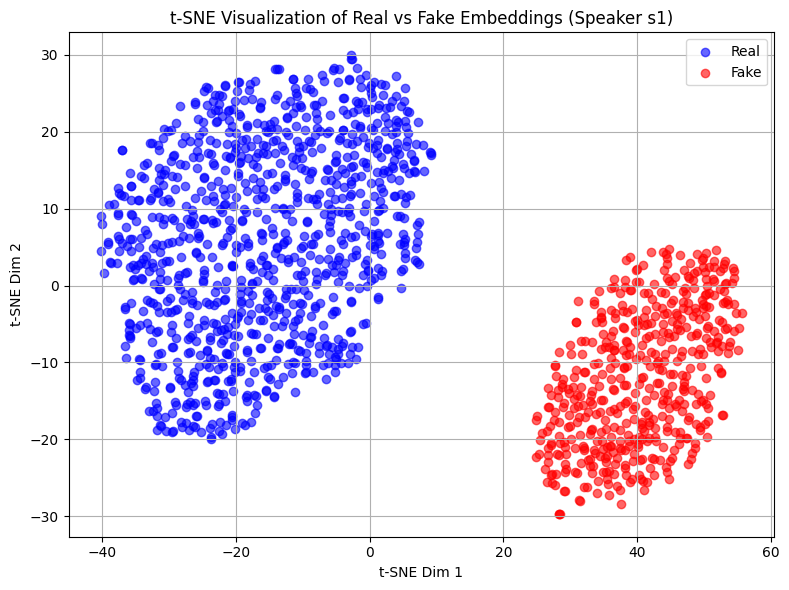

In [5]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Paths to real and fake embeddings for speaker s1
real_path = r"D:\visual_speaker_auth\data\gridcorpus\feature_embeddings\real\s1"
fake_path = r"D:\visual_speaker_auth\data\gridcorpus\feature_embeddings\fake\s1"

# Load embeddings and average them (from shape [T, 512] to [512])
def load_embeddings(path):
    embeddings = []
    files = sorted(glob(os.path.join(path, "*.npy")))
    for f in files:
        data = np.load(f)
        if len(data.shape) == 2:  # shape: (T, 512)
            pooled = np.mean(data, axis=0)
        else:  # already pooled
            pooled = data
        embeddings.append(pooled)
    return np.array(embeddings)

real_embeddings = load_embeddings(real_path)
fake_embeddings = load_embeddings(fake_path)

# Create labels and stack data
X = np.concatenate([real_embeddings, fake_embeddings], axis=0)
y = np.array([0]*len(real_embeddings) + [1]*len(fake_embeddings))  # 0 = real, 1 = fake

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], c='blue', label='Real', alpha=0.6)
plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], c='red', label='Fake', alpha=0.6)
plt.title("t-SNE Visualization of Real vs Fake Embeddings (Speaker s1)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
